# Scikit-rt applications

This notebook demonstrates how to define and run a `scikit-rt` application on datasets for multiple patients.

Documentation for `scikit-rt` is at:  
[https://scikit-rt.github.io/scikit-rt/](https://scikit-rt.github.io/scikit-rt/)


This notebook uses the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)  
https://doi.org/10.6084/m9.figshare.12579707.v1

If not already present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` in the
first code cell below.  The download file has a size of 1.6 GB, so download may take a while.

In practice, scikit-rt application code would usually run in a script, rather than in a notebook.  For a large-scale analysis, scikit-rt applications can be handled by the [ganga](https://github.com/ganga-devs/ganga) task-management system, using the [ganga-skrt](https://github.com/kh296/ganga-skrt) extension.  This allows for submission to a batch system, and for splitting tasks into multiple sub-tasks, each of which processes a subset of the patient datasets;

## Module import and data download

The following imports modules needed for this example, defines the path to the data directory, downloads the example dataset if not already present, obtains the list of paths to patient folders, and sets some viewer options.

In [1]:
from pathlib import Path
from skrt import set_viewer_options, BetterViewer, Patient
from skrt.core import alphanumeric, compress_user, download, Defaults

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)
    
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))
    
# Set Matplotlib runtime configuration (optional).
set_viewer_options()

# In place of interactive images, display static graphics that can be saved with notebook.
# Defaults().no_ui = True
# Omit user part of paths when printing object attributes.
Defaults().compress_user = True

## Scikit-rt applications

A scikit-rt application is constructed as a sequence of algorithms, each of which inherits from the [skrt.application.Algorithm](https://scikit-rt.github.io/scikit-rt/skrt.application.html#skrt.application.Algorithm) class.  This defines three methods relating to execution:

- `initialise()` - run before any patient data are read;
- `execute()` - run once for each patient;
- `finalise()` - run after all patient data have been read.

Each method returns an instance of the [skrt.application.Status](https://scikit-rt.github.io/scikit-rt/skrt.application.html#skrt.application.Status) class,
providing information on whether execution problems were encountered.  
The `initialise()` and/or `finalise()` may be omitted from a subclass if there is
no code that needs to be executed before and/or after reading patient data.

Running of algorithm methods is handled by the [skrt.application.Application](https://scikit-rt.github.io/scikit-rt/skrt.application.html#skrt.application.Application) class.

## Example application

The code in the next cell implements an algorithm for creating and saving (CSV format) a pandas Dataframe containing summary information for patient datasets, and defines a function for creating and configuring an application to use this algorithm.

In [2]:
'''
Algorithm for extracting summary data.
'''

from itertools import chain
from pathlib import Path

import pandas as pd

from skrt.application import Algorithm, Application, get_paths
from skrt.core import tic, toc

class ExtractInfo(Algorithm):
    '''
    Algorithm subclass, for extracting summary data.

    Methods:
        __init__ -- Return instance of ExtractInfo class,
                    with properties set according to options dictionary.
        execute  -- Extract summary data.
    '''

    def __init__(self, opts={}, name=None, log_level=None):
        '''
        **Parameters:**

        opts: dict, default={}
            Dictionary for setting algorithm attributes.

        name: str, default=''
            Name for identifying algorithm instance.

        log_level: str/int/None, default=None
            Severity level for event logging.  If the value is None,
            log_level is set to the value of skrt.core.Defaults().log_level.
        '''
        # Set default values for algorithm properties.
        #
        # Name of output csv file.
        self.summary_csv = 'summary_info.csv'

        # Override default properties, based on contents of opts dictionary.
        super().__init__(opts, name, log_level)

        # List of dictionaries containing summary information for patient datasets.
        self.summary_info = []
        
    def initialise(self):
        '''
        Perform any operations needed between algorithm instantiation
        and the start of execution.
        '''
        return self.status

    def execute(self, patient):
        '''
        Extract summary data for patient's dataset.

        **Parameter:**

        patient: skrt.patient.Patient/None, default=None
            Object providing access to patient dataset.
        '''
        # Print details of current patient.
        print(f'\nPatient id: {patient.id}')
        print(f'Folder path: {compress_user(patient.path)}')

        # Create data record for current patient.
        record = {
            "id": patient.id,
            "n_images": len(patient.get_images())
        }
        
        # Add record to summary information for patient datasets.
        self.summary_info.append(record)
        
        # Report time taken.
        # (Timer is started in Patient constructor.)
        self.logger.info(f"Processing time: {toc():.2f} seconds")

        return self.status

    def finalise(self):
        '''
        Write summary data to CSV file.
        '''
        df1 = pd.DataFrame(self.summary_info)
        df1.to_csv(self.summary_csv, index=False)

        return self.status


def get_app(setup_script=''):
    '''
    Define and configure application to be run.
    '''
    # Set options via a dictionary, where keywords are algorithm attributes,
    # and the associated values will be assigned to them
    # when the algorithm is instantiated.
    options = {}
    
    # Set the severity level for event logging.
    log_level = 'INFO'

    # Create algorithm object
    alg = ExtractInfo(opts=options, name=None, log_level=log_level)

    # Create the list of algorithms to be run (here just the one)
    algs = [alg]

    # Create the application
    app = Application(algs=algs, log_level=log_level)

    return app

## Running application

The application's run method is passed a list of paths to patient folders,
and may optionally be passed keyword-value pairs to be used internally when creating [skrt.patient.Patient](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Patient) objects.

In [3]:
# Define and configure the application to be run.
app = get_app()

# Algorithm options may be overwritten here.
summary_csv = "my_summary_info.csv"
app.algs[0].summary_csv = summary_csv

# Run application for the selected data.
app.run(paths[:4], unsorted_dicom=True);


Patient id: 001
Folder path: ~/data/spect_ct/SPECT_CT_data/001
ExtractInfo - INFO - Processing time: 0.54 seconds

Patient id: 002
Folder path: ~/data/spect_ct/SPECT_CT_data/002
ExtractInfo - INFO - Processing time: 0.31 seconds

Patient id: 003
Folder path: ~/data/spect_ct/SPECT_CT_data/003
ExtractInfo - INFO - Processing time: 0.33 seconds

Patient id: 004
Folder path: ~/data/spect_ct/SPECT_CT_data/004
ExtractInfo - INFO - Processing time: 0.30 seconds


## Application output

The application's CSV output may be read back to a pandas Dataframe.  Some columns may be empty.  For example, anonymised data shouldn't include patient birth dates, and the dataset used for this demo doesn't include any data from patient treatment (such as guidance images for delivering radiotherapy).

In [4]:
df = pd.read_csv(summary_csv)
print(df)

   id  n_images
0   1         4
1   2         4
2   3         5
3   4         5


## Visualising data

Dataframe data may be visualised using pandas tools.  The following plots an example histogram, showing the numbers of individual files associated with CT images (one entry per patient in the dataset).

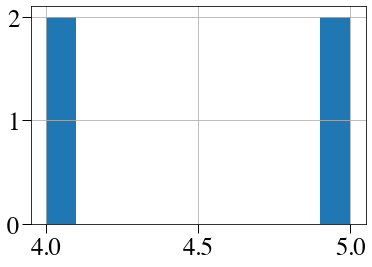

In [5]:
df["n_images"].hist();

## Developing application

After running, and understanding, the example application as initially implemented, try the following:

- add print statements at the end of the algorithm's `__init__()` method and at the beginning of the `initialise()` method, to confirm that the name of the CSV file is changed in the code cell for [Running application](#Running-application);
- edit the algorithm's `execute()` method, to include additional information in the summary;
- plot histograms for the additional information;
- remove the limit on the number of paths passed to the application, to run over the full dataset.